In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching as pm
from sampler_square import EmpiricalPnSampler
import numba
import itertools

In [3]:
@numba.njit()
def error_converter(d,E):
    """
    Convert error string to form which is more natural for the mld algorithm
    """
    f=np.zeros((2,d,d))
    for i in range(d-1):
        for j in range(d):
            f[0,j,i] = E[i*(2*d-1)+j]
        for j in range(d-1):
            f[1,j,i] = E[i*(2*d-1)+d+j]
    for j in range(d):
        f[0,j,d-1] = E[(d-1)*(2*d-1)+j]
    return f

#Optimal algorithm for maximum likmelihood decoding
@numba.njit
def initialize_M0(d):
    """
    Creation of the initial covariance metrix M0. This is the covariance matrix of the initial gaussian state |psi_e>.
    """
    M0=np.zeros((2*d,2*d))
    for i in range(d-1):
        M0[2*i+1,2*i+2]=1
        M0[2*i+2,2*i+1]=-1
    M0[0,2*d-1]=1
    M0[2*d-1,0]=-1
    return M0

@numba.njit
def simulate_H_columns(M,j,log_gamma,f,p,d):
    """
    Algorithm for simulating the action of Gaussian operator H_j.
    """
    w=np.zeros(d)
    t=np.zeros(d)
    s=np.zeros(d)
    A=np.zeros((2*d,2*d))
    B=np.zeros((2*d,2*d))
    for i in range(d):
        if f[0,j,i]==1:
            w[i]=(1-p)/p
        else:
            w[i]=p/(1-p)
        log_gamma=log_gamma+np.log((1+w[i]**2)/2)
        t[i]=(1-w[i]**2)/(1+w[i]**2)
        s[i]=2*w[i]/(1+w[i]**2)
        A[2*i,2*i+1]=t[i]
        A[2*i+1,2*i]=-t[i]
        B[2*i,2*i]=s[i]
        B[2*i+1,2*i+1]=s[i]
    log_gamma=log_gamma+np.log(np.sqrt(np.linalg.det(M+A)))
    log_gamma=log_gamma+np.log(((1-p)**(d-np.sum(f[0,j,:]))*p**np.sum(f[0,j,:]))**2)
    M=A-(B@np.linalg.inv(M+A)@B)
    return M,log_gamma

@numba.njit
def simulate_V_columns(M,j,log_gamma,f,p,d):
    """
    Algorithm for simulating the action of Gaussian operator V_j.
    """
    w=np.zeros(d-1)
    t=np.zeros(d-1)
    s=np.zeros(d-1)
    A=np.zeros((2*d,2*d))
    B=np.zeros((2*d,2*d))
    B[0,0]=1
    B[2*d-1,2*d-1]=1
    for i in range(d-1):
        if f[1,j,i]==1:
            w[i]=(1-p)/p
        else:
            w[i]=p/(1-p)
        log_gamma=log_gamma+np.log(1+w[i]**2)
        t[i]=2*w[i]/(1+w[i]**2)
        s[i]=(1-w[i]**2)/(1+w[i]**2)
        A[2*i+1,2*i+2]=t[i]
        A[2*i+2,2*i+1]=-t[i]
        B[2*i+1,2*i+1]=s[i]
        B[2*i+2,2*i+2]=s[i]
    log_gamma=log_gamma+np.log(np.sqrt(np.linalg.det(M+A)))
    log_gamma=log_gamma+np.log(((1-p)**(d-1-np.sum(f[1,j,:]))*p**np.sum(f[1,j,:]))**2)
    M=A-(B@np.linalg.inv(M+A)@B)
    return M,log_gamma

@numba.njit
def simulation_mld(p,d,f):
    """
    Calculation of ln(Z({w_E})) from an inital error string, and the probability of errors.
    """
    M0=initialize_M0(d)
    M=M0.copy()
    log_gamma=np.log(2**(d-1))
    for j in range(d-1):
        M, log_gamma=simulate_H_columns(M,j,log_gamma,f,p,d)
        M, log_gamma=simulate_V_columns(M,j,log_gamma,f,p,d)  
    M, log_gamma=simulate_H_columns(M,d-1,log_gamma,f,p,d)
    return 1/2*log_gamma-1/2*np.log(2)+np.log(np.linalg.det(M+M0)**(1/4))

def x_stabilizers(d):
    """
    make x-stabilizers for decoding with PyMatching
    x-stabilizers n dimensional bitstring, 1 where the stabilizer act with X and 0 where act with identity
    """
    x_stabs=np.zeros((d*(d-1), d**2+(d-1)**2), dtype=int)
    for i in range(d-1):
        x_stabs[i, i]=1
        x_stabs[i, i+1]=1
        x_stabs[i, i+d]=1
    for i in range(d-2):
        for j in range(d-1):
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j]=1
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+1]=1
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+d]=1
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+1-d]=1
    for i in range(d-1):
        x_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i]=1
        x_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i+1]=1
        x_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i+1-d]=1
        
    return x_stabs

In [4]:
@numba.njit
def matmul_blas(a, b):
    return np.dot(a.astype(np.float64), b.astype(np.float64))

@numba.njit
def parity_dot(a, b):
    s = 0
    for i in range(a.size):
        s ^= (a[i] & b[i])
    return s

def x_stabilizers_logical(d):
    """
    make x-stabilizers for decoding with PyMatching
    x-stabilizers n dimensional bitstring, 1 where the stabilizer act with X and 0 where act with identity
    """
    x_stabs=np.zeros((d*(d-1), d**2+(d-1)**2), dtype=np.uint8)
    for i in range(d-1):
        x_stabs[i, i]=1
        x_stabs[i, i+1]=1
        x_stabs[i, i+d]=1
    for i in range(d-2):
        for j in range(d-1):
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j]=1
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+1]=1
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+d]=1
            x_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+1-d]=1
    for i in range(d-1):
        x_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i]=1
        x_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i+1]=1
        x_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i+1-d]=1
    x_logical = np.zeros(d**2+(d-1)**2, dtype =np.uint8)
    z_logical = np.zeros(d**2+(d-1)**2, dtype = np.uint8)
    for i in range(d):
        x_logical[i*(2*d-1)] = 1
        z_logical[i] = 1
    return x_stabs, x_logical, z_logical

def stabilizers_logicals(d):
    """
    make x-stabilizers for decoding with PyMatching
    x-stabilizers n dimensional bitstring, 1 where the stabilizer act with X and 0 where act with identity
    """
    x_stabs=np.zeros((d*(d-1), d**2+(d-1)**2), dtype=np.uint8)
    for i in range(d-1):
        for j in range(d):
            if j == 0:
                x_stabs[i*d + j, i*(2*d-1) + j] = 1
                x_stabs[i*d + j, (i+1)*(2*d-1) + j] = 1
                x_stabs[i*d + j, (i)*(2*d-1) + j + d] = 1
            elif j == d-1:
                x_stabs[i*d + j, i*(2*d-1) + j] = 1
                x_stabs[i*d + j, (i+1)*(2*d-1) + j] = 1
                x_stabs[i*d + j, (i)*(2*d-1) + j + d - 1] = 1
            else:
                x_stabs[i*d + j, i*(2*d-1) + j] = 1
                x_stabs[i*d + j, (i+1)*(2*d-1) + j] = 1
                x_stabs[i*d + j, (i)*(2*d-1) + j + d] = 1
                x_stabs[i*d + j, (i)*(2*d-1) + j + d - 1] = 1
    z_stabs=np.zeros((d*(d-1), d**2+(d-1)**2), dtype=np.uint8)
    for i in range(d-1):
        z_stabs[i, i]=1
        z_stabs[i, i+1]=1
        z_stabs[i, i+d]=1
    for i in range(d-2):
        for j in range(d-1):
            z_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j]=1
            z_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+1]=1
            z_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+d]=1
            z_stabs[(i+1)*(d-1)+j, (2*d-1)*(i+1)+j+1-d]=1
    for i in range(d-1):
        z_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i]=1
        z_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i+1]=1
        z_stabs[(d-1)**2+i, (2*d-1)*(d-1)+i+1-d]=1
    x_logical = np.zeros(d**2+(d-1)**2, dtype =np.uint8)
    z_logical = np.zeros(d**2+(d-1)**2, dtype = np.uint8)
    for i in range(d):
        z_logical[i*(2*d-1)] = 1
        x_logical[i] = 1
    return x_stabs, z_stabs, x_logical, z_logical

@numba.njit(fastmath = True, parallel = True)
def fast_loop_decoding(correction_mwpm,observable_flips,p,d,logical_x, logical_z, num_shots: int):
    error_array = np.zeros(num_shots)
    error_array_mwpm = np.zeros(num_shots)
    probability = np.zeros(num_shots)
    for i in numba.prange(num_shots):
        log_P_I = simulation_mld(p, d, error_converter(d,correction_mwpm[i]))
        log_P_X = simulation_mld(p, d, error_converter(d,correction_mwpm[i]^logical_x))
        if log_P_X>log_P_I: # use the correction suggested by mld
            correction=correction_mwpm[i]^logical_x
        else:
            correction=correction_mwpm[i]
        probability[i] = np.exp(log_P_I) + np.exp(log_P_X)
       
        actual_for_shot = observable_flips[i]
        predicted_for_shot = (parity_dot(logical_z,correction))
        predicted_for_shot_mwpm = (parity_dot(logical_z,correction_mwpm[i]))
        if predicted_for_shot != actual_for_shot:
            error_array[i] = 1
        if predicted_for_shot_mwpm != actual_for_shot:
            error_array_mwpm[i] = 1
    return error_array, error_array_mwpm, probability

def logical_errors(d, p, stabilizers, logical_x, logical_z, num_shots: int):
    # Sample the circuit.
    qubit_number = stabilizers.shape[1]
    errors = np.random.binomial(1,p,(qubit_number,num_shots)).astype(np.uint8)
    detection_events = ((stabilizers@errors % 2).T).astype(np.uint8)
    observable_flips = ((logical_z@errors % 2)).astype(np.uint8)
        
    matcher = pm.Matching(stabilizers)
    correction_mwpm = matcher.decode_batch(detection_events).astype(np.uint8)
    
    error_array, error_array_mwpm, probabilities = fast_loop_decoding(correction_mwpm, observable_flips,p,d,logical_x,logical_z,num_shots)
    return detection_events, error_array, error_array_mwpm, probabilities

def count_logical_errors(detection_events,error_array,order):
    num_shots = error_array.size
    if order == 1:
        indices = np.arange(0,num_shots,1,dtype=np.int64)
    elif order == - 1:
        indices = np.where(~detection_events.any(axis=1))[0]
    else:
        sampler = EmpiricalPnSampler(detection_events,n=order)
        indices = sampler.sample_indices(k=num_shots)

    return np.sum(error_array[indices])/num_shots, np.unique(indices).size

def count_logical_errors_2(detection_events,error_array,probabilities,order):
    num_shots = error_array.size
    if order == 1:
        indices = np.arange(0,num_shots,1,dtype=np.int64)
    elif order == - 1:
        indices = np.where(~detection_events.any(axis=1))[0]
    else:
        indices = index_resampling(detection_events,probabilities,k=order)

    return np.sum(error_array[indices])/num_shots, np.unique(indices).size

def index_resampling(detection_events,probabilities,k):
    n = probabilities.size
    uniques, inverse= np.unique(detection_events, axis=0, return_inverse=True)
    order = np.argsort(inverse, kind="mergesort")
    inv_sorted = inverse[order]
    probs = probabilities[order]

    boundaries = np.flatnonzero(np.diff(inv_sorted)) + 1
    groups_all = np.split(order, boundaries)
    probs_all = np.split(probs, boundaries)

    probs = np.array([p[0]**k for p in probs_all])
    probs = probs/np.sum(probs)

    g_idx = np.random.choice(len(groups_all), size=n, p=probs)
    out = np.empty(n, dtype=int)
    for t, g in enumerate(g_idx):
        grp = groups_all[g]
        out[t] = grp[np.random.randint(len(grp))]
    return out

def direct_Z_calc(error,logical,stabs,p):
    n = stabs.shape[0]
    Z_1 = 0
    Z_2 = 0
    error2 = (error + logical)%2
    for i in range(2**n):
        k=i
        newerror = error.copy()
        newerror2 = error2.copy()
        for j in range(n):
            if k%2 == 1:
                newerror = (newerror+stabs[j])%2
                newerror2 = (newerror2+stabs[j])%2
            k = k//2
        Z_1 += p**np.sum(newerror)*(1-p)**(newerror.size - np.sum(newerror))
        Z_2 += p**np.sum(newerror2)*(1-p)**(newerror2.size - np.sum(newerror2))
    return Z_1, Z_2

@numba.njit(fastmath = True, parallel = True)
def syndrome_probabilities(correction_mwpm,p,d,logical_x, num_shots: int):
    probability = np.zeros(num_shots)
    for i in numba.prange(num_shots):
        log_P_I = simulation_mld(p, d, error_converter(d,correction_mwpm[i]))
        log_P_X = simulation_mld(p, d, error_converter(d,correction_mwpm[i]^logical_x))
        probability[i] = np.exp(log_P_I) + np.exp(log_P_X)
       
    return probability


In [ ]:
p = 0.1
d = 3
stabs, logical_x, logical_z = stabilizers_logicals(d)
error = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])
z1,z2 = direct_Z_calc(error,logical_x,stabs,p)
print(z1,z2)
log_P_I = simulation_mld(p, d, error_converter(d,error))
log_P_Z = simulation_mld(p, d, error_converter(d,error^logical_x))
print(np.exp(log_P_I),np.exp(log_P_Z))

0.25576131024000004 0.0014035809599999996
0.2557613102399999 0.0014035809599999996


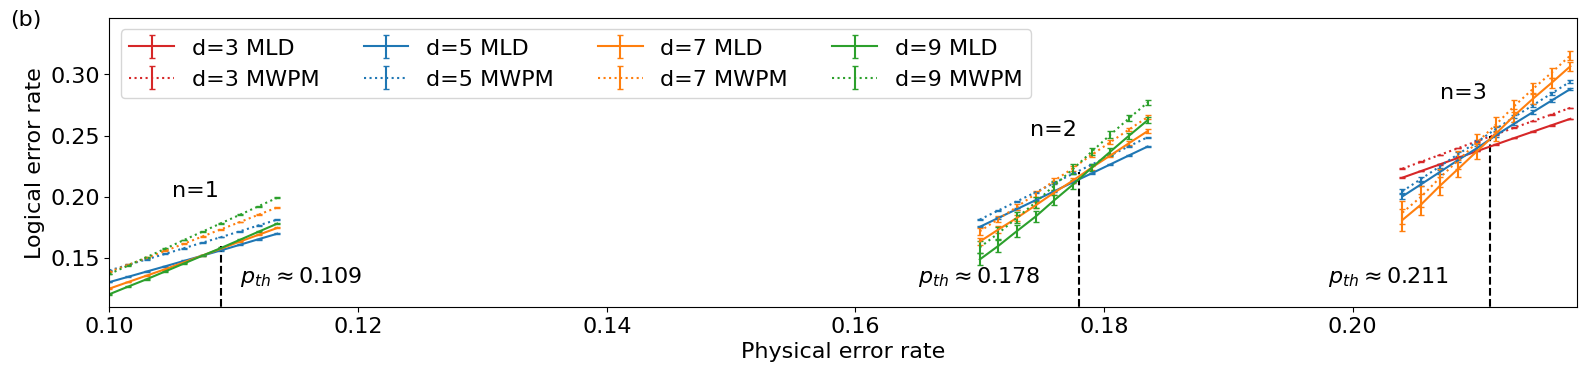

In [ ]:
results = np.zeros((3,4,10))
error = np.zeros((2,4,10))
p = np.zeros(10)

for j in range(4):
    d = 3+2*j
    for i in range(10):
        p[i] = 0.17 + 0.0015*i
        data = np.loadtxt('data/final_logical_error_order_2_d_'+str(d)+'_p_'+str(p[i])+'.txt')
        data2 = np.loadtxt('data/new_logical_error_order_2_d_'+str(d)+'_p_'+str(p[i])+'.txt')
        results[0,j,i] = data[0]
        results[1,j,i] = data[1]
        results[2,j,i] = data2[0]
        error[0,j,i] = data[2]
        error[1,j,i] = data[3]
        if j == 3:
            for i in range(10):
                p[i] = 0.17 + 0.0015*i
                data = np.loadtxt('data/new_logical_error_order_2_d_'+str(d)+'_p_'+str(p[i])+'.txt')
                results[2,j,i] = data[0]
            for k in range(9):
                for i in range(10):
                    p[i] = 0.17 + 0.0015*i
                    data = np.loadtxt('data/new_logical_error_order_2_d_'+str(d)+'_p_'+str(p[i])+'_seed_'+str(17+k)+'.txt')
                    results[2,j,i] += data[0]
            results[2,3,:] = results[2,3,:]/10  

results2 = np.zeros((2,3,10))
error2 = np.zeros((2,3,10))
p2 = np.zeros(10)

for j in range(3):
    d = 3+2*j
    if j == 2:
        for i in range(10):
            p2[i] = 0.204 + 0.0015*i
            data2 = np.loadtxt('data/final_logical_error_order_3_d_'+str(d)+'_p_'+str(p2[i])+'.txt')
            results2[0,j,i] = data2[0]
            results2[1,j,i] = data2[1]
            error2[0,j,i] = data2[2]
            error2[1,j,i] = data2[3]
    else:
        for i in range(10):
            p2[i] = 0.204 + 0.0015*i
            data2 = np.loadtxt('data/new_logical_error_order_3_d_'+str(d)+'_p_'+str(p2[i])+'.txt')
            results2[0,j,i] = data2[0]
            results2[1,j,i] = data2[1]
            error2[0,j,i] = data2[2]
            error2[1,j,i] = data2[3]

results3 = np.zeros((2,4,10))
error3 = np.zeros((2,4,10))
p3 = np.zeros(10)

for j in range(4):
    d = 3+2*j
    for i in range(10):
        p3[i] = 0.1 + 0.0015*i
        data3 = np.loadtxt('data/final_logical_error_order_1_d_'+str(d)+'_p_'+str(p3[i])+'.txt')
        results3[0,j,i] = data3[0]
        results3[1,j,i] = data3[1]
        error3[0,j,i] = data3[2]
        error3[1,j,i] = data3[3]

plt.rcParams['font.size'] = 16
colors = ['tab:red','tab:blue','tab:orange','tab:green']
plt.figure(figsize=(16, 4))
for j in range(3):
    if j == 0:
        plt.errorbar(p2, results2[0,j,:],yerr = error2[0,j,:],capsize=2,color = colors[j], label = 'd='+str(3+2*j)+' MLD')
        plt.errorbar(p2, results2[1,j,:],yerr = error2[1,j,:],capsize=2,fmt =':', color = colors[j], label = 'd='+str(3+2*j)+' MWPM')
    else:
        plt.errorbar(p2, results2[0,j,:],yerr = error2[0,j,:],capsize=2,color = colors[j])
        plt.errorbar(p2, results2[1,j,:],yerr = error2[1,j,:],capsize=2,fmt =':', color = colors[j])
for j in range(1,4):
    plt.errorbar(p, results[0,j,:],yerr = error[0,j,:],capsize=2,color = colors[j], label = 'd='+str(3+2*j)+' MLD')
    plt.errorbar(p, results[1,j,:],yerr = error[1,j,:],capsize=2,fmt =':', color = colors[j], label = 'd='+str(3+2*j)+' MWPM')
for j in range(1,4):
    plt.errorbar(p3, results3[0,j,:],yerr = error3[0,j,:],capsize=2,color = colors[j])
    plt.errorbar(p3, results3[1,j,:],yerr = error3[1,j,:],capsize=2,fmt =':', color = colors[j])

thresholds = [0.109,0.178,0.211]
ymax = [0.16,0.22,0.25]
for i in range(3):
    plt.plot([thresholds[i],thresholds[i]],[0,ymax[i]],'--',color = 'black')
    if i == 0:
        plt.text(thresholds[i]+0.0015,0.13,r'$p_{th}\approx$'+str(thresholds[i]))
    else:
        plt.text(thresholds[i]-0.013,0.13,r'$p_{th}\approx$'+str(thresholds[i]))
plt.legend(loc = 'upper left',ncol=4)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.xlim(0.1,0.218)
plt.ylim(0.11,0.346)
plt.text(0.105,0.2,'n=1')
plt.text(0.174,0.25,'n=2')
plt.text(0.207,0.28,'n=3')
plt.text(0.092,0.34,'(b)')

plt.tight_layout()
#plt.savefig('threshold_plots.pdf')

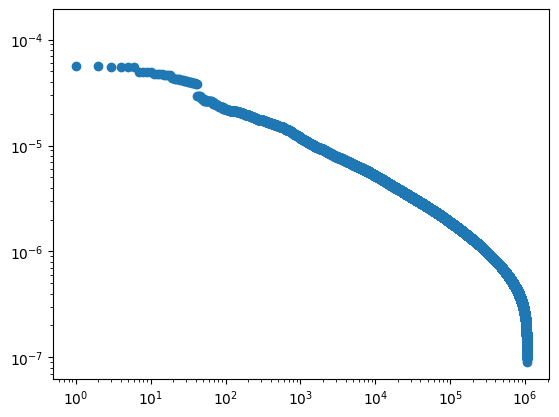

In [26]:
d = 5
p = 0.2

num_stabs = (d**2+(d-1)**2 - 1)//2
x_stabs, z_stabs, logical_x, logical_z = stabilizers_logicals(d)
syndromes = np.zeros((2**num_stabs,num_stabs),dtype=int)

counter = 0
for syn in itertools.product([0,1],repeat=num_stabs):
    syndromes[counter] = np.array(syn)
    counter += 1
matcher = pm.Matching(z_stabs)
correction_mwpm = matcher.decode_batch(syndromes).astype(np.uint8)

probabilities = syndrome_probabilities(correction_mwpm,p,d,logical_x,2**num_stabs)

np.save('probabilities_p0.2_d5.npy',probabilities)

plt.scatter(np.arange(2**num_stabs),np.sort(probabilities)[::-1])
plt.yscale('log')
plt.xscale('log')

In [ ]:
probabilities2 = probabilities**2
probabilities2 = probabilities2/np.sum(probabilities2)
probabilities3 = probabilities**3
probabilities3 = probabilities3/np.sum(probabilities3)
x= np.sort(probabilities)[::-1]

1048576
[      0       1       2 ... 1048573 1048574 1048575]


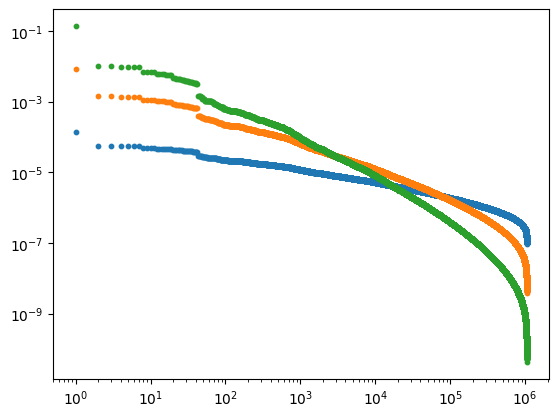

In [25]:
plt.scatter(np.arange(1,2**num_stabs+1),np.sort(probabilities)[::-1],s=10)
plt.scatter(np.arange(1,2**num_stabs+1),np.sort(probabilities2)[::-1],s=10)
plt.scatter(np.arange(1,2**num_stabs+1),np.sort(probabilities3)[::-1],s=10)
plt.yscale('log')
plt.xscale('log')

Text(500000.0, 2e-05, 'n=3')

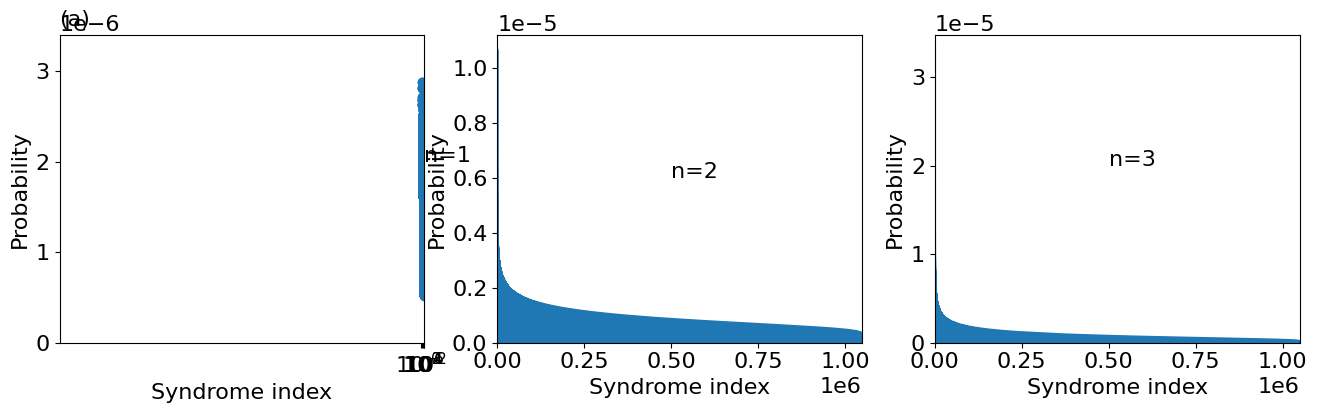

In [138]:
plt.rcParams['font.size'] = 16

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].text(-14e4,35e-7,'(a)')
axs[0].scatter(np.arange(2**num_stabs),np.sort(probabilities)[::-1])
#axs[0].fill_between(np.arange(2**num_stabs),np.zeros(2**num_stabs),np.sort(probabilities)[::-1],color = 'tab:blue')
axs[0].set_xlim(0,2**num_stabs)
axs[0].set_ylim(0)
axs[0].set_xlabel('Syndrome index')
axs[0].set_ylabel('Probability')
axs[0].set_xscale('log')
axs[0].text(5e5,2e-6,'n=1')

axs[1].plot(np.arange(2**num_stabs),np.sort(probabilities2)[::-1])
axs[1].fill_between(np.arange(2**num_stabs),np.zeros(2**num_stabs),np.sort(probabilities2)[::-1],color = 'tab:blue')
axs[1].set_xlim(0,2**num_stabs)
axs[1].set_ylim(0)
axs[1].set_xlabel('Syndrome index')
axs[1].set_ylabel('Probability')
axs[1].text(5e5,6e-6,'n=2')

axs[2].plot(np.arange(2**num_stabs),np.sort(probabilities3)[::-1])
axs[2].fill_between(np.arange(2**num_stabs),np.zeros(2**num_stabs),np.sort(probabilities3)[::-1],color = 'tab:blue')
axs[2].set_xlim(0,2**num_stabs)
axs[2].set_ylim(0)
axs[2].set_xlabel('Syndrome index')
axs[2].set_ylabel('Probability')
axs[2].text(5e5,20e-6,'n=3')

#plt.tight_layout()
#plt.savefig('Syndrome_distribution.pdf')

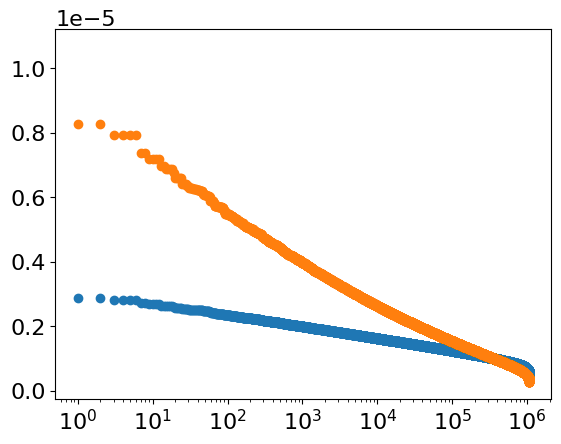

In [141]:
plt.scatter(np.arange(2**num_stabs),np.sort(probabilities)[::-1])
plt.xscale('log')
#plt.figure(2)
plt.scatter(np.arange(2**num_stabs),np.sort(probabilities2)[::-1])
plt.xscale('log')